# Dependencies

In [ ]:
import keras
import tqdm
import tensorflow as tf
import keras.backend as K

from keras import losses
from keras.engine import InputSpec
from keras.engine.topology import Layer
from keras.utils import conv_utils
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
from keras.layers import Input, Activation, Add, UpSampling2D, BatchNormalization, Conv2D, Dense, concatenate, GlobalAveragePooling2D, AveragePooling2D, Flatten, Lambda
from keras.layers.merge import Add
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.backend.common import normalize_data_format

In [9]:
from PIL import Image, ImageEnhance
import random
import cv2
import math
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
import click
import datetime

In [3]:
# If running the notebook on Google Colab, else change the paths in the following cells accordingly
# Please add the dataset to your Google Drive, mount your Drive by running this cell.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model Architecture

In [ ]:
# Parameters as defined in the paper
test_image_folder = "/content/drive/My Drive/ProcessedDeblurGAN_Dataset/ImgEnh/blurred/"
channel_rate = 64
image_shape = (256, 256, 3)
patch_shape = (channel_rate, channel_rate, 3)
RESHAPE = (256, 256)
ngf = 64
ndf = 64
input_nc = 3
output_nc = 3
input_shape_generator = (256, 256, input_nc)
input_shape_discriminator = (256, 256, output_nc)
n_blocks_gen = 9

In [ ]:
def res_block(input, filters, kernel_size=(3, 3), strides=(1, 1), use_dropout=False):
    """
    Instantiates a Resnet Block using sequential API.

    Parameters
    input: Input tensor
    filters: Number of filters to use
    kernel_size: Shape of the kernel for the convolution
    strides: Shape of the strides for the convolution
    use_dropout: Boolean value to determine the use of dropout
    
    Returns
    Keras Model
    """
    block = ReflectionPadding2D((1, 1))(input)
    # convolutional layer
    block = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,)(block)
    
    # normalization
    block = BatchNormalization()(block)

    # ReLu activation Function
    block = Activation('relu')(block)

    # if use_dropout is true then 5% of the neurons will be off
    if use_dropout:
        block = Dropout(0.5)(block)

    block = ReflectionPadding2D((1, 1))(block)
    block = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,)(block)
    block = BatchNormalization()(block)

    #  concatenate input and result
    merged = Add()([input, block])
    return merged

In [ ]:
def spatial_reflection_2d_padding(x, padding=((1, 1), (1, 1)), data_format=None):
    """
    Pad the 2nd and 3rd dimensions of a 4D tensor.

    Parameters
    x: Input tensor
    padding: Shape of padding to use
    data_format: Tensorflow vs Theano convention ('channels_last', 'channels_first')
    
    Returns
    Tensorflow tensor
    """
    assert len(padding) == 2
    assert len(padding[0]) == 2
    assert len(padding[1]) == 2

    if data_format is None:
        data_format = image_data_format()
    
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format ' + str(data_format))

    if data_format == 'channels_first':
        pattern = [[0, 0],
                   [0, 0],
                   list(padding[0]),
                   list(padding[1])]
    else:
        pattern = [[0, 0],
                   list(padding[0]), list(padding[1]),
                   [0, 0]]
    return tf.pad(x, pattern, "REFLECT")

In [ ]:
class ReflectionPadding2D(Layer):

    def __init__(self,
                 padding=(1, 1),
                 data_format=None,
                 **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)
        self.data_format = normalize_data_format(data_format)
        if isinstance(padding, int):
            self.padding = ((padding, padding), (padding, padding))
        elif hasattr(padding, '__len__'):
            if len(padding) != 2:
                raise ValueError('`padding` should have two elements. '
                                 'Found: ' + str(padding))
            height_padding = conv_utils.normalize_tuple(padding[0], 2,
                                                        '1st entry of padding')
            width_padding = conv_utils.normalize_tuple(padding[1], 2,
                                                       '2nd entry of padding')
            self.padding = (height_padding, width_padding)
        else:
            raise ValueError('`padding` should be either an int, '
                             'a tuple of 2 ints '
                             '(symmetric_height_pad, symmetric_width_pad), '
                             'or a tuple of 2 tuples of 2 ints '
                             '((top_pad, bottom_pad), (left_pad, right_pad)). '
                             'Found: ' + str(padding))
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            if input_shape[2] is not None:
                rows = input_shape[2] + self.padding[0][0] + self.padding[0][1]
            else:
                rows = None
            if input_shape[3] is not None:
                cols = input_shape[3] + self.padding[1][0] + self.padding[1][1]
            else:
                cols = None
            return (input_shape[0],
                    input_shape[1],
                    rows,
                    cols)
        elif self.data_format == 'channels_last':
            if input_shape[1] is not None:
                rows = input_shape[1] + self.padding[0][0] + self.padding[0][1]
            else:
                rows = None
            if input_shape[2] is not None:
                cols = input_shape[2] + self.padding[1][0] + self.padding[1][1]
            else:
                cols = None
            return (input_shape[0],
                    rows,
                    cols,
                    input_shape[3])

    def call(self, inputs):
        return spatial_reflection_2d_padding(inputs,
                                             padding=self.padding,
                                             data_format=self.data_format)

    def get_config(self):
        config = {'padding': self.padding,
                  'data_format': self.data_format}
        base_config = super(ReflectionPadding2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
def generator_model():
    """Build generator architecture."""
    # initialize input with (256, 256, 3)
    inputs = Input(shape=image_shape)

    x = ReflectionPadding2D((3, 3))(inputs)

    # convolutional layer with kernel size = (7, 7) padding = valid it will reduce the output filter
    x = Conv2D(filters=ngf, kernel_size=(7, 7), padding='valid')(x)

    # batch normalization after convolutional layer
    x = BatchNormalization()(x)

    #  ReLu activation function
    x = Activation('relu')(x)

    n_downsampling = 2
    for i in range(n_downsampling):
        mult = 2**i
        x = Conv2D(filters=ngf*mult*2, kernel_size=(3, 3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    mult = 2**n_downsampling
    for i in range(n_blocks_gen):
        x = res_block(x, ngf*mult, use_dropout=True)

    for i in range(n_downsampling):
        mult = 2**(n_downsampling - i)
        # x = Conv2DTranspose(filters=int(ngf * mult / 2), kernel_size=(3, 3), strides=2, padding='same')(x)
        x = UpSampling2D()(x)
        x = Conv2D(filters=int(ngf * mult / 2), kernel_size=(3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    x = ReflectionPadding2D((3, 3))(x)
    x = Conv2D(filters=output_nc, kernel_size=(7, 7), padding='valid')(x)
    x = Activation('tanh')(x)

    outputs = Add()([x, inputs])
    # outputs = Lambda(lambda z: K.clip(z, -1, 1))(x)
    outputs = Lambda(lambda z: z/2)(outputs)

    model = Model(inputs=inputs, outputs=outputs, name='Generator')
    return model

In [ ]:
def discriminator_model():
    """Build discriminator architecture."""
    
    n_layers, use_sigmoid = 3, False
    inputs = Input(shape=input_shape_discriminator)

    x = Conv2D(filters=ndf, kernel_size=(4, 4), strides=2, padding='same')(inputs)
    # in testing LeakyRelu worked better than sigmoid or ReLu with a=0.2
    x = LeakyReLU(0.2)(x)

    nf_mult, nf_mult_prev = 1, 1
    for n in range(n_layers):
        nf_mult_prev, nf_mult = nf_mult, min(2**n, 8)
        x = Conv2D(filters=ndf*nf_mult, kernel_size=(4, 4), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

    nf_mult_prev, nf_mult = nf_mult, min(2**n_layers, 8)
    x = Conv2D(filters=ndf*nf_mult, kernel_size=(4, 4), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(filters=1, kernel_size=(4, 4), strides=1, padding='same')(x)
    if use_sigmoid:
        x = Activation('sigmoid')(x)

    x = Flatten()(x)
    x = Dense(1024, activation='tanh')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=x, name='Discriminator')
    return model


In [ ]:
def generator_containing_discriminator(generator, discriminator):
    inputs = Input(shape=image_shape)
    generated_image = generator(inputs)
    outputs = discriminator(generated_image)
    model = Model(inputs=inputs, outputs=outputs)
    return model

def generator_containing_discriminator_multiple_outputs(generator, discriminator):
    inputs = Input(shape=image_shape)
    generated_image = generator(inputs)
    outputs = discriminator(generated_image)
    model = Model(inputs=inputs, outputs=[generated_image, outputs])
    return model

In [ ]:
# Defining losses

def perceptual_loss(y_true, y_pred):
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=image_shape)
    loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
    loss_model.trainable = False
    return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))

# adversarial loss
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

# Utility Functions

In [ ]:
def is_an_npy_file(filename):
    # Checks if the given file is a .npy file
    NPY_EXTENSIONS = ['.npy']
    for ext in NPY_EXTENSIONS:
        if ext in filename:
            return True
    return False


def list_npy_files(directory):
    # Lists all the .npy files in a directory

    files = sorted(os.listdir(directory))
    return [os.path.join(directory, f) for f in files if is_an_npy_file(f)]


def load_npy(path):
    # Loads a .npy file from a given path

    npy = np.load(path)
    return npy


def preprocess_npy(npy):
    # Preprocess the .npy file

    npy = (npy - 127.5) / 127.5
    return npy

In [ ]:
def load_npys(path, n_npy):
    # Load n_npy number of .npy files from a given path randomly

    if n_npy < 0:
        n_npy = float("inf")
    A_paths, B_paths = os.path.join(path, 'A'), os.path.join(path, 'B')
    all_A_paths, all_B_paths = list_npy_files(
        A_paths), list_npy_files(B_paths)
    
    zipped_lists = list(zip(all_A_paths, all_B_paths))
    random.shuffle(zipped_lists)

    all_A_paths, all_B_paths = zip(*zipped_lists)

    npy_A, npy_B = [], []
    npy_A_paths, npy_B_paths = [], []
    for path_A, path_B in zip(all_A_paths, all_B_paths):
        np_A, np_B = load_npy(path_A), load_npy(path_B)
        npy_A.append(preprocess_npy(np_A))
        npy_B.append(preprocess_npy(np_B))
        npy_A_paths.append(path_A)
        npy_B_paths.append(path_B)
        if len(npy_A) > n_npy - 1:
            break

    return {
        'A': np.array(npy_A),
        'A_paths': np.array(npy_A_paths),
        'B': np.array(npy_B),
        'B_paths': np.array(npy_B_paths)
    }

In [ ]:
def deprocess_image(img):
    # Deprocess the image file

    img = img * 127.5 + 127.5
    return img.astype('uint8')


def save_image(np_arr, path):
    # Save the image from the corresponsing numpy array

    img = np_arr * 127.5 + 127.5
    im = Image.fromarray(img)
    im.save(path)


def save_all_weights(d, g, epoch_number, current_loss):
    # Save all weights of the discriminator and generator models on given epoch number and loss value
    
    g.save(os.path.join('/content/drive/My Drive/ProcessedDeblurGAN_Dataset', 'generator_{}_{}.h5'.format(epoch_number+100, current_loss)))
    d.save(os.path.join('/content/drive/My Drive/ProcessedDeblurGAN_Dataset', 'discriminator_{}.h5'.format(epoch_number+100)))

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib."""
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

# Training

In [ ]:
def train_multiple_outputs(n_images, batch_size, epoch_num, critic_updates=5, train=False):
    if train==True:
        data = load_npys('/content/drive/My Drive/ProcessedDeblurGAN_Dataset/ProcessedImages/train', n_images)
        y_train, x_train = data['B'], data['A']

    g = generator_model()
    d = discriminator_model()
    d_on_g = generator_containing_discriminator_multiple_outputs(g, d)

    d_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    d_on_g_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)


    d.trainable = True
    d.compile(optimizer=d_opt, loss=wasserstein_loss)
    d.trainable = False
    # adding the two losses
    # adversarial loss = wasserstein loss
    # and perceptual loss
    loss = [perceptual_loss, wasserstein_loss]
    loss_weights = [100, 1]
    d_on_g.compile(optimizer=d_on_g_opt, loss=loss, loss_weights=loss_weights)
    d.trainable = True

    output_true_batch, output_false_batch = np.ones((batch_size, 1)), -np.ones((batch_size, 1))

    if train==True:
        for epoch in tqdm.tqdm(range(epoch_num)):
            permutated_indexes = np.random.permutation(x_train.shape[0])

            d_losses = []
            d_on_g_losses = []
            for index in range(int(x_train.shape[0] / batch_size)):
                batch_indexes = permutated_indexes[index*batch_size:(index+1)*batch_size]
                image_blur_batch = x_train[batch_indexes]
                image_full_batch = y_train[batch_indexes]

                generated_images = g.predict(x=image_blur_batch, batch_size=batch_size)

                for _ in range(critic_updates):
                    d_loss_real = d.train_on_batch(image_full_batch, output_true_batch)
                    d_loss_fake = d.train_on_batch(generated_images, output_false_batch)
                    d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
                    d_losses.append(d_loss)

                d.trainable = False

                d_on_g_loss = d_on_g.train_on_batch(image_blur_batch, [image_full_batch, output_true_batch])
                d_on_g_losses.append(d_on_g_loss)

                d.trainable = True

            print(np.mean(d_losses), np.mean(d_on_g_losses))

            if epoch%5==0:
              save_all_weights(d, g, epoch, int(np.mean(d_on_g_losses)))


In [ ]:
train_multiple_outputs(n_images=4, batch_size=1, epoch_num=1, train=False)

# Testing

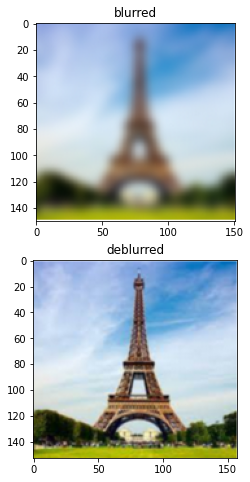

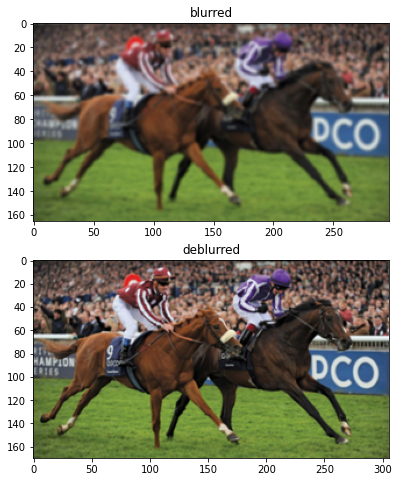

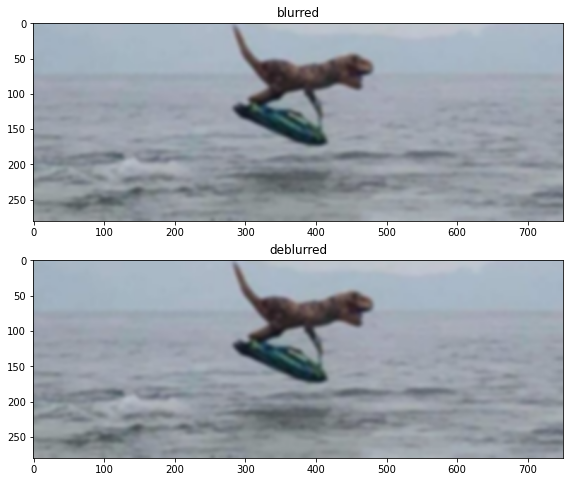

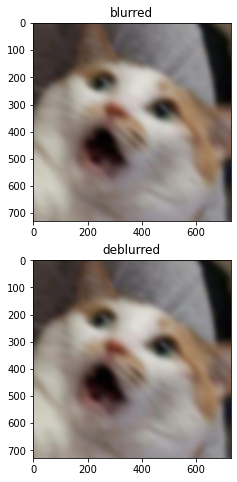

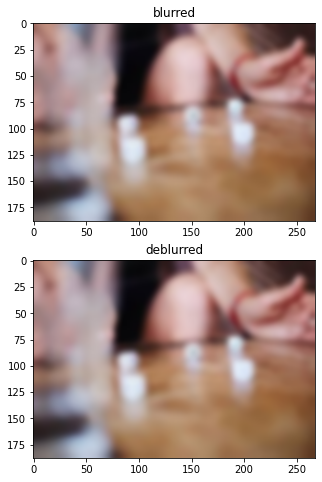

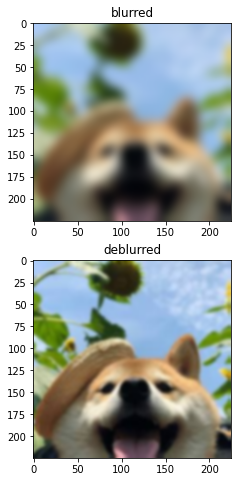

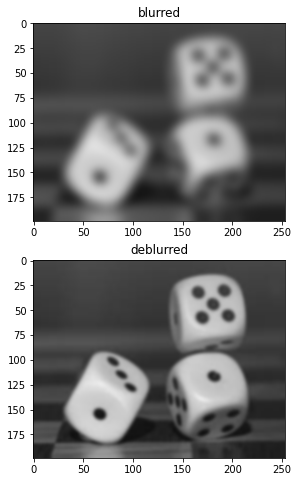

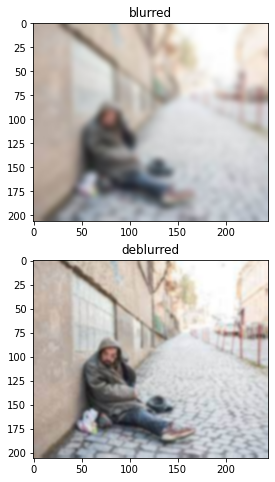

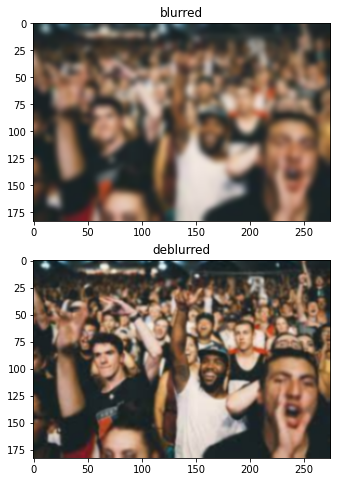

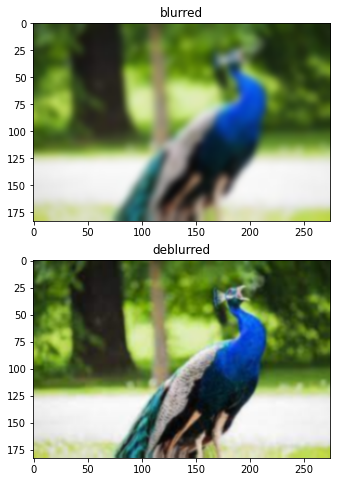

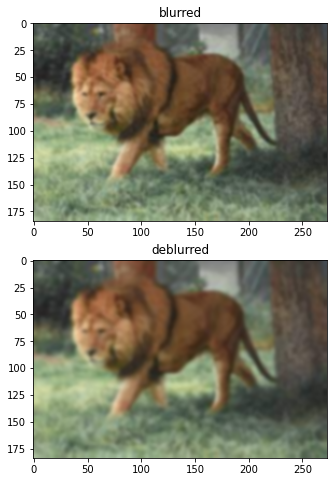

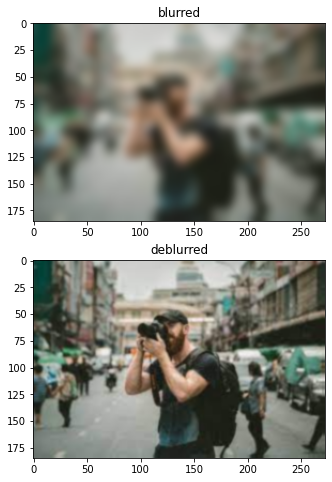

In [20]:
def test(batch_size):
    data = load_npys('/content/drive/My Drive/ProcessedDeblurGAN_Dataset/ProcessedImages/test', batch_size)
    y_test, x_test = data['B'], data['A']
    g = generator_model()
    g.load_weights('/content/drive/My Drive/ProcessedDeblurGAN_Dataset/generator_195_204.h5')
    generated_images = g.predict(x=x_test, batch_size=batch_size)
    generated = np.array([deprocess_image(img) for img in generated_images])
    x_test = deprocess_image(x_test)
    y_test = deprocess_image(y_test)

    for i in range(generated_images.shape[0]):
        y = y_test[i, :, :, :]
        x = x_test[i, :, :, :]
        img = generated[i, :, :, :]
        
        cv2.imwrite("/content/drive/My Drive/ProcessedDeblurGAN_Dataset/ImgEnh/deblurred/" + str(i) + ".png", img)
        cv2.imwrite("/content/drive/My Drive/ProcessedDeblurGAN_Dataset/ImgEnh/blurred/" + str(i) + ".png", x)
        cv2.imwrite("/content/drive/My Drive/ProcessedDeblurGAN_Dataset/ImgEnh/target/" + str(i) + ".png", y)

        im = Image.open("/content/drive/My Drive/ProcessedDeblurGAN_Dataset/ImgEnh/deblurred/" + str(i) + ".png")
        enhancer = ImageEnhance.Brightness(im)
        enhanced_im = enhancer.enhance(1.05)
        enhanced_im.save("/content/drive/My Drive/ProcessedDeblurGAN_Dataset/ImgEnh/deblurredFixed/" + str(i) + ".png")

        output = np.concatenate((y, x, img), axis=1)
        im = Image.fromarray(output.astype(np.uint8))
        im.save('results{}.png'.format(i))
    return generated_images

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib."""
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

def display_test_results(image_folder):
    for index in range(1, len(os.listdir(image_folder))+1):
        deblurred = Image.open("/content/drive/My Drive/ProcessedDeblurGAN_Dataset/ImgEnh/deblurred/" + str(index) + ".png")
        blurred = Image.open("/content/drive/My Drive/ProcessedDeblurGAN_Dataset/ImgEnh/blurred/" + str(index) + ".png")
        show_images(images=[blurred, deblurred], cols=2, titles=["blurred", "deblurred"])

display_test_results(test_image_folder)

# Evaluation Metrics

- PSNR
- SSIM

In [ ]:
sess = tf.InteractiveSession()
avg_psnr1 = 0
avg_psnr2 = 0
for i in range(100):
    deblurred = Image.open("/content/drive/My Drive/ProcessedDeblurGAN_Dataset/ImgEnh/predicted/" + str(i) + ".png")
    target = Image.open("/content/drive/My Drive/ProcessedDeblurGAN_Dataset/ImgEnh/target/" + str(i) + ".png")
    blurred = Image.open("/content/drive/My Drive/ProcessedDeblurGAN_Dataset/ImgEnh/blurred/" + str(i) + ".png")

    deblurred = np.array(deblurred)
    target = np.array(target)
    blurred = np.array(blurred)

    deblurred = deblurred.reshape(1,256,256,3)
    target = target.reshape(1,256,256,3)
    blurred = blurred.reshape(1,256,256,3)

    psnr1= tf.image.psnr(tf.convert_to_tensor(target,dtype=tf.float32), tf.convert_to_tensor(deblurred,dtype=tf.float32), max_val=255)
    psnr2= tf.image.psnr(tf.convert_to_tensor(target,dtype=tf.float32), tf.convert_to_tensor(blurred,dtype=tf.float32), max_val=255)
    
    avg_psnr1 += psnr1
    avg_psnr2 += psnr2

    print(i)
    print("PSNR P-T: " + str(psnr1.eval()) + " PSNR H-T: " + str(psnr2.eval()))
    print("\n")

avg_psnr1 = avg_psnr1.eval()
avg_psnr2 = avg_psnr2.eval()
print(avg_psnr1/100)
print(avg_psnr2/100)
sess.close()

In [ ]:
sess = tf.InteractiveSession()
avg_ssim1 = 0
avg_ssim2 = 0
for i in range(100):
    deblurred = Image.open("/content/drive/My Drive/ProcessedDeblurGAN_Dataset/ImgEnh/predicted/" + str(i) + ".png")
    target = Image.open("/content/drive/My Drive/ProcessedDeblurGAN_Dataset/ImgEnh/target/" + str(i) + ".png")
    blurred = Image.open("/content/drive/My Drive/ProcessedDeblurGAN_Dataset/ImgEnh/blurred/" + str(i) + ".png")

    deblurred = np.array(deblurred)
    target = np.array(target)
    blurred = np.array(blurred)

    deblurred = deblurred.reshape(1,256,256,3)
    target = target.reshape(1,256,256,3)
    blurred = blurred.reshape(1,256,256,3)
    
    ssim1= tf.image.ssim(tf.convert_to_tensor(target,dtype=tf.float32), tf.convert_to_tensor(deblurred,dtype=tf.float32), max_val=255)
    ssim2= tf.image.ssim(tf.convert_to_tensor(target,dtype=tf.float32), tf.convert_to_tensor(hazy,dtype=tf.float32), max_val=255)
    
    avg_ssim1 += ssim1
    avg_ssim2 += ssim2
    
    print(i)
    print("SSIM DT: " + str(ssim1.eval()) + " SSIM DFT: " + str(ssim2.eval()))
    print("\n")

avg_ssim1 = avg_ssim1.eval()
avg_ssim2 = avg_ssim2.eval()
print(avg_ssim1/100)
print(avg_ssim2/100)
sess.close()